# **Generalized linear models**

In [ ]:
library(tidyverse)

These models don't rely on the assumption that residuals are normally distributed

## Binomial distribution

The binomial distribution focuses data with two outcomes, 0 and 1. It has two parameters. $n$ = number of trials, and $p$ = proportion of trials with a positive outcome. The theoretical variance of the binomial distribution is

$$
\sigma^2 = np (1 - p)
$$

The code block below illustrates how when a binomial distribution contains mostly 0's or mostly 1's, its variance is low, but when it contains an even mix of 0's and 1's, its variance is high.

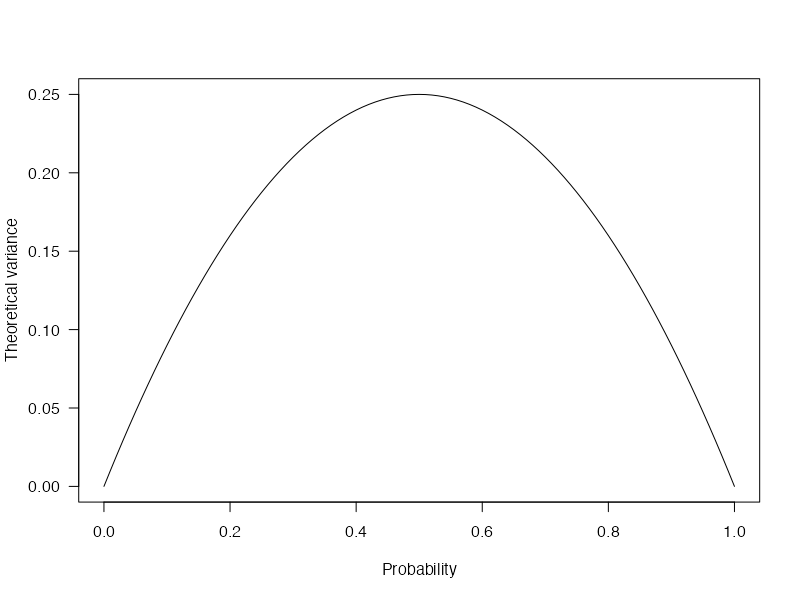

In [62]:
x = seq(from=0, to=1, by=0.01)
v_b = x*(1-x) #Binomial variance
plot(x, v_b, type="l", xlab="Probability", ylab="Theoretical variance", las=1)

This difference in variance can be a problem. To solve it, we want to transform the data to make it approach a normal distribution. We can use the logit function

$$
logit(x) = log(\frac{x}{x-1})
$$

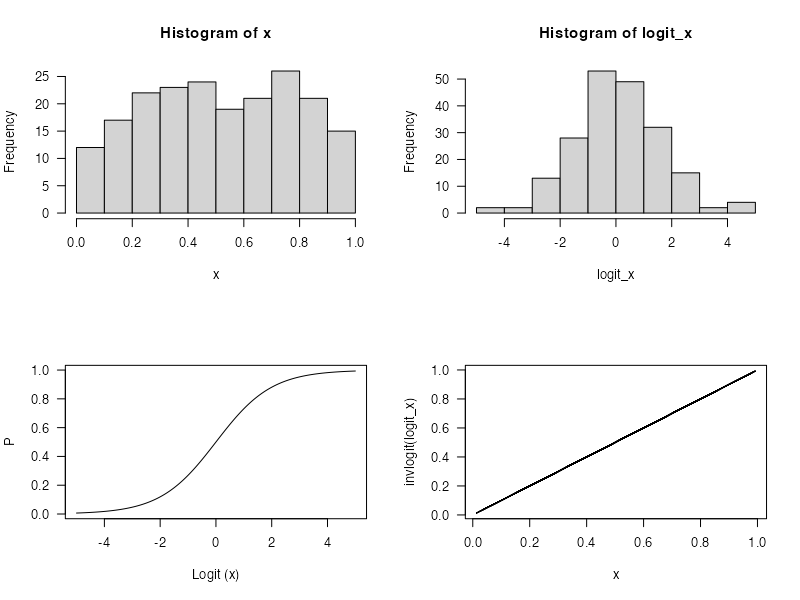

In [63]:
set.seed(0)

# Define functions
logit = function(x) log(x/(1-x))
invlogit = function(x) 1/(1+exp(-x))

x = runif(200)
logit_x = logit(x)  # Apply logit function to distribution of random uniform values between 0 and 1

par(mfrow=c(2,2))
hist(x, las=1)
hist(logit_x, las=1)

xx = seq(-5, 5, 0.01)
plot(xx, invlogit(xx), type="l", las=1, xlab="Logit (x)", ylab="P")
plot(x, invlogit(logit_x), type="l", las=1)

The logit function is a *link function* in a GLM with binomial errors.

The *probit link/function* is an alternative to the logit function.

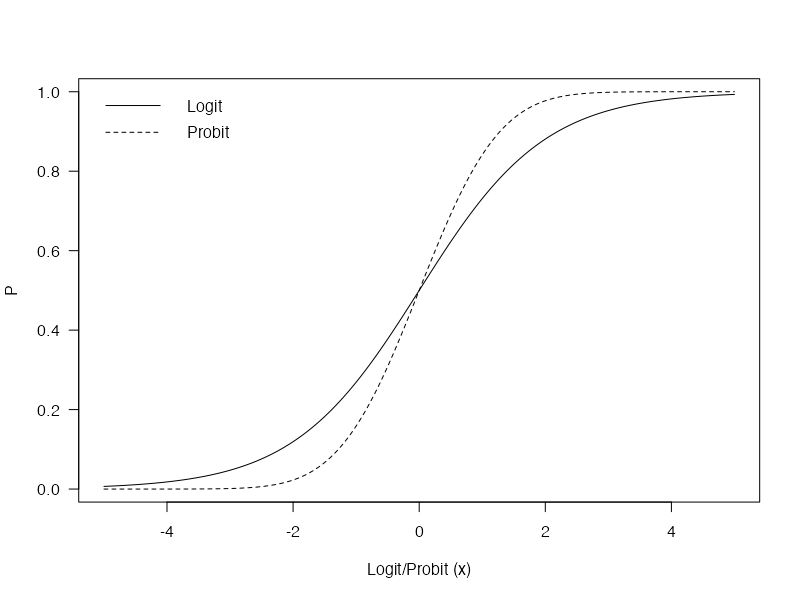

In [65]:
plot(xx, invlogit(xx), type="l", las=1, xlab="Logit/Probit (x)", ylab="P")
lines(xx, pnorm(xx), lty=2)
legend("topleft", legend=c("Logit", "Probit"), lty=c(1,2), bty="n")

## Logistic regression

To demonstrate logistic regression, we simulate the data below
1. Formulate linear predictor $\eta$
2. Transform values into probabilities using `invlogit`
3. Binarize by sampling from the binary distribution

# A tibble: 200 × 2
       p     y
   <dbl> <int>
 1 0.655     0
 2 0.895     1
 3 0.107     0
 4 0.967     1
 5 0.328     0
 6 0.616     0
 7 0.617     0
 8 0.470     1
 9 0.627     1
10 0.180     0
# ℹ 190 more rows
# ℹ Use `print(n = ...)` to see more rows


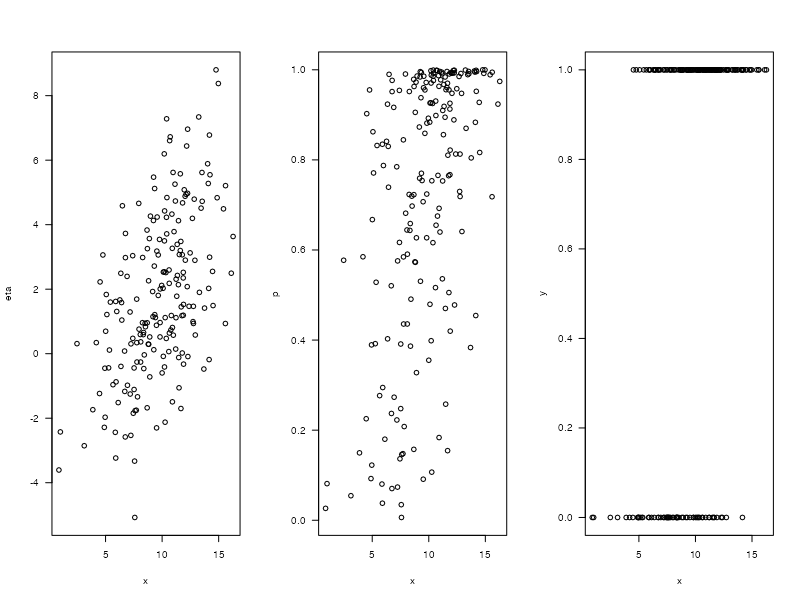

In [107]:
set.seed(99)

x = rnorm(200, 10, 3)
eta = -2 + 0.4*x + rnorm(200, 0, 2)  # See the y=mx+b being applied to the normal distribution
p = invlogit(eta)
y = rbinom(200, 1, p)  # Sample 200 times, 1 trial per data point, with probability p success on each trial

# In the dataframe below: a data point has a probability of being true or false, influences what we observe
df <- tibble(p, y)
print(df)

par(mfrow=c(1,3))
plot(x, eta, las=1)
plot(x, p, las=1)
plot(x, y, las=1)

### Fitting a generalized model

Use `glm`, specify the error family `binomial`, link `logit` function

In [88]:
m = glm(y~x, family=binomial(link="logit"))
summary(m)


Call:
glm(formula = y ~ x, family = binomial(link = "logit"))

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.39843    0.60565  -3.960 7.49e-05 ***
x            0.33950    0.06489   5.232 1.68e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 250.75  on 199  degrees of freedom
Residual deviance: 216.00  on 198  degrees of freedom
AIC: 220

Number of Fisher Scoring iterations: 4


Notes on the summary table above:
- We obtain parameter estimates on the link scale (here *logit*)
    - Compare with $\eta$ when data was generated. They should be similar
    - If a predictor variable has units $m$, the slopes have units $log \; odds \; m^{-1}$

It can be useful to backtransform the data to the probability scale (between 0-1)
- Log odds of 0 corresponds with a probability of 0.5 since $log(\frac{0.5}{1-0.5}) = log(1) = 0$
- Solving the model equation (the linear predictor) for 0 gives the predictor value for $p=0.5$
$$
0 = \beta_0 + \beta_x x
$$
$$
\frac{-\beta_0}{\beta_x} = x
$$

### Exercise
Create a plot with observations and linear model on the probability scale with lines at $p=0.5$ and $p(0.5)$. To produce a regression line, we define some new x-values that spans the data range along the x-axis, then obtain predicted values $\hat{y}$ (using the model coefficients), and finally transform these values to the probability scale to obtain the predicted probabilities $\hat{p}$.

Code given:

In [89]:
# Code given
coefs = summary(m)$coef
x_pred = seq(from=min(x), to=max(x), by=0.01)  # Values of x to generate predictions of y for
y_hat = coefs[1,1] + coefs[2,1]*x_pred  # Predict outputs of x_pred in the linear form (on the link (logit) scale)
p_hat = invlogit(y_hat)  # Transform the predictions onto the probability scale

print(coefs)

              Estimate Std. Error   z value     Pr(>|z|)
(Intercept) -2.3984306 0.60564858 -3.960103 7.491751e-05
x            0.3395048 0.06489484  5.231615 1.680354e-07


Code produced:

To find $x$ where $log \; odds \; y = 0$ (`y_loggods`) or $p = 0.5$ (`y_p`) 

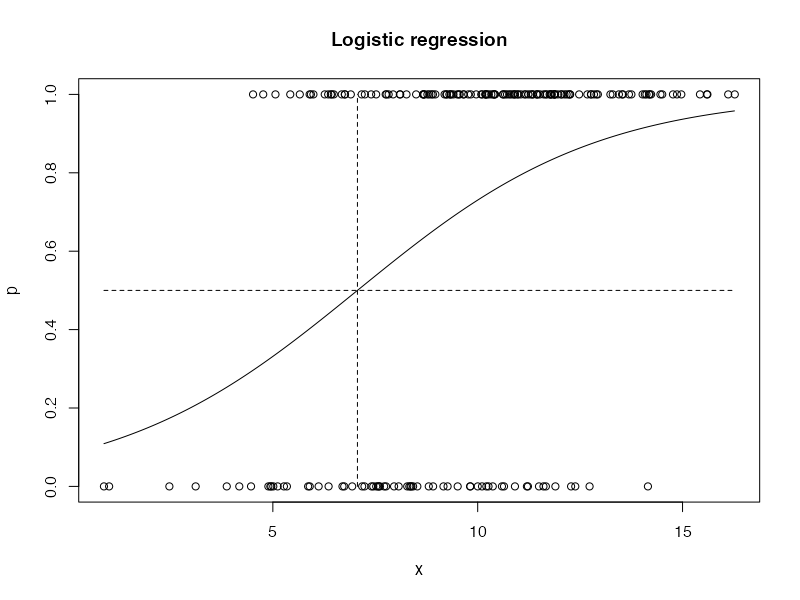

In [120]:
# Solve model
y_p <- 0.5
beta_0 <- coefs[1,1]  # Set intercept of the model to beta_0
beta_x <- coefs[2,1]  # Set slope of the model to beta_x
y_logodds <- logit(y_p)  # Set y to solve for on the log odds scale

x_50 <- (y_logodds - beta_0) / beta_x  # Solve for x when log odds y is 0

# Set bounds to the vertical and horizontal lines
vlinebounds <- c(0, 1)
hlinebounds <- c(min(x), max(x))

# Plot
par(mfrow = c(1,1))
plot(x_pred, p_hat, type = "l", ylim = vlinebounds, xlab = "x", ylab = "p", main = "Logistic regression")
points(rep(x_50, 2), vlinebounds, type = "l", lty = 2)
points(hlinebounds, rep(y_p, 2), type = "l", lty = 2)
points(x, y)

There are no $r^2$ in GLMs. There are other approaches that use maximum likelihood instead.

In [122]:
library(MuMIn)
r.squaredGLMM(m)

Warning message:
the null model is only correct if all the variables it uses are identical 
to those used in fitting the original model. 


                  R2m       R2c
theoretical 0.2340753 0.2340753
delta       0.1795071 0.1795071

Computing **coefficient of discrimination** $D$.

$D$ is defined as

$$
D = \overline{\hat{\pi_1}} - \overline{\hat{\pi_0}}
$$

where $\overline{\hat{\pi_1}}$ represents the average distance between the regression line and 1, and $\overline{\hat{\pi_0}}$ represents the average distance between the regression line and 0. In other words, $D$ scales with the steepness of the linear regressor. A long and smooth S-curve will have a low $D$ and an abrupt, steep S-curve will have a high $D$.

In [129]:
y_hat = coefs[1,1] + coefs[2,1]*x  # Predicted output, log odds scale
p_hat = invlogit(y_hat)  # Predicted output, probability scale

# Generate pi values by taking the mean of probabilities for each class
pi_1 <- mean(p_hat[which(y==1)])
pi_0 <- mean(p_hat[which(y==0)])

D <- pi_1 - pi_0
cat("D", "=", D)

D = 0.1657763

### Formulating GLMs in R

If the data are 0's and 1's like above

```r
glm(y ~ x, family=binomial(link="logit"))
```

However, when each observation is based on more than one trial, we can formulate the models in these ways

```r
glm(y ~ x, family=binomial(link="logit"), weights=n)
```

where `y` is the proportion of success and `n` is the number of trials

Or

```r
glm(cbind(successes, failures) ~ x, family=binomial(link="logit"))
```

`cbind(successes, failures)` is a two-column matrix, where the columns represent the number of successes and the number of failures

---

## Exercise: seed germination

Seeds were left to dry (aka after-ripened) for different times before they were germinated. After after-ripening, their germination success was measured.

Goal: estimate a pattern of germination success in response to the variation in the duration of after-ripening

In [130]:
library(here)

here() starts at /Users/otodreas/Lund/Courses/BIOS15/BIOS15-Coursework


In [151]:
# Import data
df <- as_tibble(read.csv(here("Exercises", "Exercise-5-LogReg", "Data", "dormancy.csv")))
df

# A tibble: 941 × 8
   pop   mother crossID blocktray timetosowing MCseed nseed germ2
   <chr> <chr>  <chr>   <chr>            <int>  <dbl> <int> <dbl>
 1 LM    LM1    LM1sld  T3_1                61 -2.34      2     0
 2 LM    LM1    LM1shd  T3_1                64 -0.136     2     0
 3 LM    LM1    LM1xld  T1_1                64  2.66      2     0
 4 LM    LM1    LM1xhd  T2_1                64  4.76      2     0
 5 LM    LM2    LM2sld  T4_1                37  2.56      2     0
 6 LM    LM2    LM2shd  T7_1                65 -0.436     2     0
 7 LM    LM2    LM2xld  T9_1                37  1.36      2     0
 8 LM    LM2    LM2xhd  T7_1                64  0.764     2     0
 9 LM    LM3    LM3sld  T8_1                56  0.264     2     0
10 LM    LM3    LM3shd  T5_1                46 -0.136     2     0
# ℹ 931 more rows
# ℹ Use `print(n = ...)` to see more rows

In [178]:
# Fit model
sub_df <- df %>% filter(pop == "CC")
germ <- sub_df$germ2 * sub_df$nseed  # Successes
notgerm <- sub_df$nseed - germ  # Failures

mod1 = glm(cbind(germ, notgerm) ~ timetosowing, "binomial", data=sub_df)
mod2 = glm(germ2 ~ timetosowing, "binomial", weights=nseed, data=sub_df)
logLik(mod1) == logLik(mod2)  # Note that these two models have the same log likelihood

[1] TRUE

Task: use the fitted models to estimate the duration of after-ripening required for the expected germination rate to be 0.5.

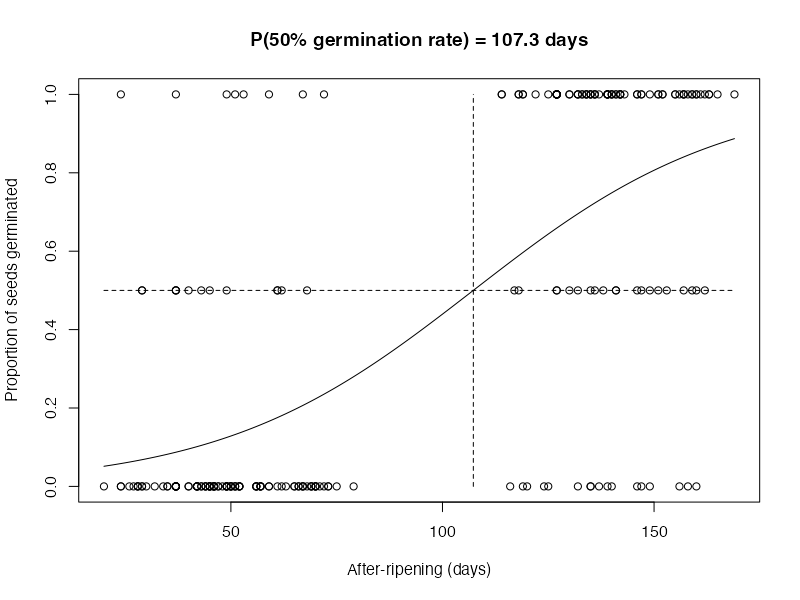

In [ ]:
# Functions
logit = function(x) log(x/(1-x))
invlogit <- function(x) 1/(1+exp(-x))

# Store raw data in vectors
after_ripening <- sub_df$timetosowing
germ <- sub_df$germ2
after_ripening_bounds <- c(min(after_ripening), max(after_ripening))
p_bounds <- c(0, 1)

# Initialize coefficients
coefs <- mod1$coefficients
beta_0 <- coefs[1]
beta_x <- coefs[2]

# Get model output at steps in after ripening time
after_ripening_steps <- seq(after_ripening_bounds[1], after_ripening_bounds[2])
germ_logodds <- beta_0 + after_ripening_steps * beta_x
germ_p <- invlogit(germ_logodds)

# Initialize variables using set probability
germ_var_p <- 0.5
germ_var_logodds <- logit(germ_var_p)

# Solve for duration of after-ripening when germination is expected to be equal to set point
after_ripening_50 <- (germ_var_logodds - beta_0) / beta_x

# Plot
plot(
  after_ripening, germ, xlab = "After-ripening (days)", ylab = "Proportion of seeds germinated",
  main = paste0(
    "P(", germ_var_p * 100, "% germination rate) = ", round(after_ripening_50, 1), " days"
  )
)
points(after_ripening_steps, germ_p, type = "l")
points(rep(after_ripening_50, 2), p_bounds, type = "l", lty = 2)
points(after_ripening_bounds, rep(germ_var_p, 2), type = "l", lty = 2)